# Аугментация текстовых данных  

## Загрузка необходимых модулей 

In [ ]:
!pip3 transformers

In [ ]:
!pip3 install sacremoses

In [ ]:
!pip3 install pymystem3

In [ ]:
!pip3 install deep_translator

In [1]:
from transformers import T5ForConditionalGeneration, T5Tokenizer, logging
from sklearn.preprocessing import PolynomialFeatures
import dependency_paraphraser.natasha
import random
from deep_translator import GoogleTranslator
import torch
from tqdm import tqdm
from typing import List, Tuple
from transformers import pipeline, BertTokenizer, AutoTokenizer, AutoModelForSeq2SeqLM
from tqdm import trange
import math
from nltk.tokenize import word_tokenize
import requests
import re
import nltk
import numpy as np
import os
import warnings
import pandas as pd
from pymystem3 import Mystem
import matplotlib.pyplot as plt
from gensim.models import Word2Vec, KeyedVectors

2023-04-14 00:01:00.863544: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
logging.set_verbosity_error()

In [23]:
file = open("../data/stop_words_russian.txt", "r")
stop_words = file.read().splitlines()

In [24]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [25]:
'''version 
sklearn 0.22.2.post1
numpy 1.23.0
gensim 3.8.3'''

'version \nsklearn 0.22.2.post1\nnumpy 1.23.0\ngensim 3.8.3'

In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
random.seed(42)

In [27]:
ru_rnc = {'A' : 'ADJ', 'ADV' : 'ADV', 'ADVPRO' : 'ADV', 
          'ANUM' : 'ADJ', 'APRO' : 'DET', 'COM' : 'ADJ', 
         'CONJ' : 'SCONJ', 'INTJ' : 'INTJ', 'NONLEX' : 'X',
         'NUM': 'NUM', 'PART': 'PART', 'PR' : 'ADP',
         'S' : 'NOUN', 'SPRO' : 'PRON', 'UNKN' : 'X', 'V' : 'VERB'}

In [28]:
ru_un = {'!': '.', 'A': 'ADJ', 'C': 'CONJ', 'AD': 'ADV', 'NNS' : 'NOUN', 'NNP' : 'NOUN', 
         'NN': 'NOUN', 'VG': 'VERB', 'COMP': 'CONJ',
         'NC': 'NUM', 'VP': 'VERB', 'P': 'ADP',
         'IJ': 'X', 'V': 'VERB', 'Z': 'X', 'VI': 'VERB', 'YES_NO_SENT': 'X', 'PTCL': 'PRT', 
        'VBP' : 'VBP', 'VBN' : 'VERB', 'VBG' : 'VERB', 'VBD' : 'VERB', 'VB' : 'VERB'}

## Работа с данными

In [29]:
df = pd.read_csv('../datasets/foss/dataset_max_25.csv', index_col=0)
df.shape

(7980, 2)

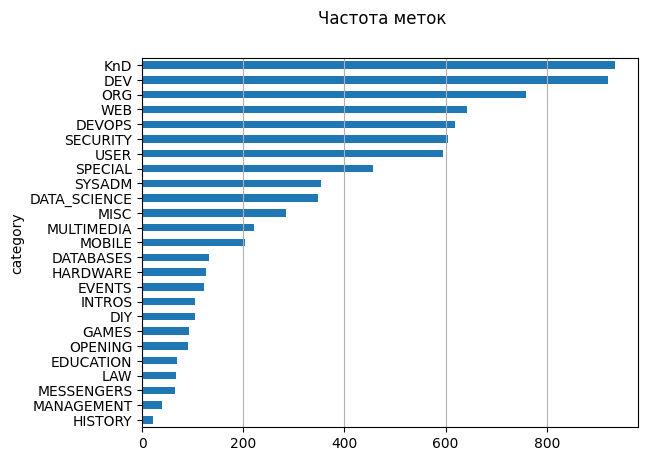

In [30]:
fig, ax = plt.subplots()
fig.suptitle("Частота меток", fontsize=12)
df['category'].reset_index().groupby('category').count().sort_values(by= 
       'index').plot(kind='barh', legend=False, 
        ax=ax).grid(axis='x')
plt.show()

In [31]:
def normalize_text(text):
    # приведение к нижнему регистру 
    lower_result = text.lower()
    # удаление url-адресов
    non_links_result = re.sub(r"\S*https?:\S*", "", lower_result)
    # удаление emails
    non_emails_result = re.sub(r"\S*@\S*\s?", "", non_links_result)
    # удаление цифр
    non_numeric_result = ''.join([i for i in non_emails_result if not i.isdigit()])
    # удаление пунктуации и специальных символов
    non_punc_result = ''.join(filter(lambda mark: ord(mark) == 774 or mark.isalnum() or mark.isspace(), non_numeric_result)).strip()
    # удаление лишних пробелов
    non_space_result = re.sub(r" +", " ", non_punc_result)
    # удаление лишних абзацев
    paragraph_list = non_space_result.split('\n')
    text = '\n'.join([p for p in paragraph_list if not p.count(' ') < 10])
    # удаление стоп-слов и длинных слов
    text_tokens = word_tokenize(text)
    without_stop_word_tokens = [word for word in text_tokens if not word in stop_words]
    without_long_tokens = [word for word in without_stop_word_tokens if len(word) <= 18]
    without_short_tokens = [word for word in without_long_tokens if len(word) >= 2]
    
    return (" ").join(without_short_tokens)  

In [32]:
def get_split(text):
    l_total = []
    l_parcial = []
    count = len(text.split())//100
    if count > 0:
        n = count
    else: 
        n = 1
    for w in range(n):
        if w == 0:
            l_parcial = text.split()[:100]
            l_total.append(" ".join(l_parcial))
        else:
            l_parcial = text.split()[w*100:w*100 + 100]
            l_total.append(" ".join(l_parcial))
    return l_total

## Аугментация методом перефразировки

In [33]:
def paraphraser(
    texts: List, # тексты для перефразировки
    labels: List, # метки текстов
    grams: int = 5, # 5-8 
    beams_number: int = 1, # количество лучей для генерации новой последовательности
    sequences_number: int = 3, # количество новых текстов, которое необходимо сгенерировать для каждого сэмпла
    top_k: int = 150, # 50-150
    top_p: float = 0.8, # сохраняются только наиболее вероятные токены, sum(p) > top_p. 0.6-0.9
    model_name: str = 'cointegrated/rut5-base-paraphraser') \
        -> Tuple[List, List]: # два списка - новые тексты и их метки
    
    model = T5ForConditionalGeneration.from_pretrained(model_name)
    tokenizer = T5Tokenizer.from_pretrained(model_name)

    #model.cuda() 
    model.eval()

    new_texts, new_labels = [], []
    #for text, label in tqdm(zip(texts, labels), total=len(texts), desc='paraphraser'):
    for text, label in zip(texts, labels):
        x = tokenizer(text, return_tensors='pt', padding=True).to(model.device)
        max_size = int(x.input_ids.shape[1] * 1.5 + 10)
        
        out = model.generate(**x, 
                             encoder_no_repeat_ngram_size=grams, 
                             num_beams=beams_number, 
                             max_length=max_size, 
                             num_return_sequences=sequences_number,
                             do_sample=True, 
                             top_k=top_k,
                             top_p=top_p) 
                             #temperature=1.5)
        
        result_texts = tokenizer.batch_decode(out, skip_special_tokens=True)
        
        for t in set(result_texts):
            if t != text:
                new_texts.append(t)
                new_labels.append(label)

    return new_texts, new_labels

In [ ]:
#new_texts, new_labels = paraphraser([texts], [labels])
#assert len(new_texts) > 0
#assert len(new_labels) == len(new_texts)

### Другие парефразеры

In [ ]:
# на вход подается нормализованный текст 
dependency_paraphraser.natasha.paraphrase(text, tree_temperature=1)

In [ ]:
# на вход подается нормализованный текст. min_sim -- минимальное расстояние для замены. 
# p_rep -- количество замененных слов
navec_model = dependency_paraphraser.natasha.emb.as_gensim
random.seed(42)
for i in range(3):
    print(dependency_paraphraser.natasha.paraphrase(text1, w2v=navec_model, p_rep=0.6, min_sim=0.55))

## Аугментация методом обратного перевода

In [34]:
def back_translation(
    texts: List, # тексты для аугментации
    labels: List, # метки текстов
    src: str = 'ru', # язык, с которого переводить
    tgt: str = 'en', # язык, на который переводить
    batch_size: int = 20) \
        -> Tuple[List, List]: # два списка - новые тексты и их метки
    
    new_texts, new_labels = [], []
    text = texts[0]
    
    try:
        #z = 1/0
        
        tokenizer = AutoTokenizer.from_pretrained(f"Helsinki-NLP/opus-mt-{src}-{tgt}")
        model = AutoModelForSeq2SeqLM.from_pretrained(f"Helsinki-NLP/opus-mt-{src}-{tgt}")
        
        #model.cuda()

        input_ids = tokenizer.encode(text, return_tensors="pt") #.to(model.device)
        outputs = model.generate(input_ids, max_length=500)
        decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)

        tokenizer = AutoTokenizer.from_pretrained(f"Helsinki-NLP/opus-mt-{tgt}-{src}")
        model = AutoModelForSeq2SeqLM.from_pretrained(f"Helsinki-NLP/opus-mt-{tgt}-{src}")

        #model.cuda()
        
        input_ids = tokenizer.encode(decoded, return_tensors="pt") #.to(model.device)
        outputs = model.generate(input_ids, max_length=500)
        decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)

        if decoded != text:
            new_texts.append(decoded)
            new_labels.append(labels[0])
            
        #translator = pipeline(task='translation', model=f'Helsinki-NLP/opus-mt-{src}-{tgt}')
        #translator_back = pipeline(task='translation', model=f'Helsinki-NLP/opus-mt-{tgt}-{src}')


        #for step in trange(0, len(texts), batch_size, desc='back_translation'):
        #for step in range(0, len(texts), batch_size):

             #texts[step:step+batch_size] -> texts[step], labels[step:step+batch_size] -> labels[step]

            #transleted = [t['translation_text'] for t in translator(texts[step:step+batch_size], truncation='only_first')]
            #back = [t['translation_text'] for t in translator_back(transleted, truncation='only_first')]

            #for t, b, l in zip(texts[step:step+batch_size], back, labels[step:step+batch_size]):
                #if t != b:
                 #   new_texts.append(b)
                 #   new_labels.append(l)
    except:
        try:
            translated = GoogleTranslator(source='ru', target='en').translate(text)
            back = GoogleTranslator(source='en', target='ru').translate(translated)
             
            if back != text:
                new_texts.append(back)
                new_labels.append(labels[0])
        except:
            print("Error not translated.")
            return [''], [-1]
                
    return new_texts, new_labels

In [35]:
#new_texts, new_labels = back_translation([texts], [labels])
#assert len(new_texts) > 0
#assert len(new_labels) == len(new_texts)

## Аугментация методом контекстной замены случайного токена

In [36]:
#cointegrated/rubert-tiny2 DeepPavlov/rubert-base-cased bert-base-multilingual-cased
def contextual_replacement(
    texts: List, # тексты для аугментации
    labels: List, # метки текстов
    top_k: int = 2, # топ-k замен выбрать для аугментации каждого сэмпла
    part: float = 0.5, # замена слов с вероятностью part  
    model_name: str = 'cointegrated/rubert-tiny2') \
-> Tuple[List, List]: # два списка - новые тексты и их метки
    
    fill_mask = pipeline('fill-mask', model=model_name)
    
    new_texts, new_labels = [], []
    #for text, label in tqdm(zip(texts, labels), total=len(texts), desc='contextual_replacer'):
    for text, label in zip(texts, labels):
        split_text = text.split()
        length = len(split_text)
        
        length_20percent = round(length*part)
        
        indexes = random.sample(range(length), length_20percent)
        
        for index in indexes:
            token = split_text[index]
            split_text[index] = '[MASK]'
            #join_text = " ".join(split_text)
            result_replace = fill_mask(" ".join(split_text), top_k=top_k)
            for item in result_replace:
                if item['token_str'] != token:
                    split_text[index] = item['token_str']
                    break
                else:
                    split_text[index] = token
        
        new_texts.append(' '.join(split_text))
        new_labels.append(label)

    return new_texts, new_labels

In [37]:
#new_texts, new_labels = contextual_replacement([texts], [labels])
#assert len(new_texts) > 0
#assert len(new_labels) == len(new_texts)

## Аугментация методом контекстной вставки случайного токена

In [38]:
#cointegrated/rubert-tiny2 DeepPavlov/rubert-base-cased bert-base-multilingual-cased
def contextual_insertion(
    texts: List, # тексты для аугментации
    labels: List, # метки текстов
    top_k: int = 1, # топ-k замен выбрать для аугментации каждого сэмпла
    part: float = 0.5, # вставка слов с вероятностью part 
    model_name: str = 'cointegrated/rubert-tiny2') \
-> Tuple[List, List]: # два списка - новые тексты и их метки
    
    fill_mask = pipeline('fill-mask', model=model_name)
    
    new_texts, new_labels = [], []
    #for text, label in tqdm(zip(texts, labels), total=len(texts), desc='contextual_insertion'):
    for text, label in zip(texts, labels):
        split_text = text.split()
        with_mask_text = list()
        
        length = len(split_text)
        length_20percent = math.trunc(length*part)
        
        indexes = sorted(random.sample(range(length), length_20percent))
        
        for i in range(length):
            if i in indexes:
                with_mask_text.append('[MASK]') 
            with_mask_text.append(split_text[i])
        
        indexes = [i for i in range(len(with_mask_text)) if with_mask_text[i] == '[MASK]']
        
        for index in indexes:
            non_masks = list()
            for i in range(index+1, len(with_mask_text)):
                if with_mask_text[i] == '[MASK]':
                    continue
                non_masks.append(with_mask_text[i])
            with_first_mask = with_mask_text[0:index+1] + non_masks
            result_replace = fill_mask(" ".join(with_first_mask), top_k=1)
            for item in result_replace:
                with_mask_text[index] = item['token_str']
                break
   
        new_texts.append(' '.join(with_mask_text))
        new_labels.append(label)

    return new_texts, new_labels                  

In [39]:
#new_texts, new_labels = contextual_insertion([texts], [labels])
#assert len(new_texts) > 0
#assert len(new_labels) == len(new_texts)

## EDA: Easy Data Augmentation Techniques

In [40]:
def get_tag(word) \
-> Tuple[str, str]: # лексема и тэг слова word
    
    if check_english(word):
        lex = word
        try:
            pos = ru_un[nltk.pos_tag([word])[0][1]]
        except:
            return word, 'NOUN'
    else:
        m = Mystem()
        processed = m.analyze(word)[0]

        lex = processed["analysis"][0]["lex"].lower().strip()
        pos = processed["analysis"][0]["gr"].split(',')[0]
        pos = pos.split('=')[0].strip()

    return lex, pos

In [41]:
def check_english(word):
    return bool(re.search('[a-zA-Z]', word))

In [42]:
def synonym_replacement_word2vec(text: str, part: float = 0.5) \
-> str: # аугментированный текст
    
    words = text.split()
    
    new_words = words.copy()
    
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    
    length = len(random_word_list)
    length_20percent = math.trunc(length*part)

    for index, random_word in enumerate(random_word_list):
        synonyms = get_neighbors(random_word)
        if len(synonyms) > 0:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
        if index >= length_20percent:
            break
    text = ' '.join(new_words)

    return text

In [43]:
def get_neighbors_with_word2vec(
    word: str,
    model) \
-> List: # список самых 'близких' слов к word
    
    lex, pos = get_tag(word)
    if not check_english(word):
        pos = ru_rnc[pos]

    word = lex + '_' + pos
    
    try: 
        #model = KeyedVectors.load_word2vec_format('220/model.bin', binary=True)
        neighbors_sim = model.most_similar(word)
    except:
        return []
    
    tokens = [word for (word,sim) in neighbors_sim]
    
    neighbors = list()
    for token in tokens:
        tag = token.split('_', 1)[1]
        word = token.split('_', 1)[0]

        if word != lex and tag == pos:
            neighbors.append(word)
    
    
    return neighbors

In [44]:
def get_neighbors_with_rusvectores(
    word: str,
    model: str = 'ruwikiruscorpora_upos_cbow_300_10_2021',
    format_: str = 'csv') \
-> List: # список самых 'близких' слов к word
    
    lex, pos = get_tag(word)
    #tag = word_tag.split('_', 1)[1]
    if not check_english(word):
        pos = ru_rnc[pos]

    word = lex + '_' + pos
    
    neighbors = list()
    
    url = '/'.join(['https://rusvectores.org', model, word, 'api', format_]) + '/'
    r = requests.get(url=url, stream=True)
          
    for line in r.text.split('\n'):
        try:
            token, sim = re.split('\s+', line)
            tag = token.split('_', 1)[1]
            word = token.split('_', 1)[0]

            if word != lex and tag == pos:
                neighbors.append(word)
        except:
            continue
    
    return neighbors

In [45]:
def synonym_replacement(text: str, model = None, part: float=0.5, method='word2vec') \
-> str: # аугментированный текст
    
    words = text.split()
    
    synonyms = list()
    new_words = words.copy()
    
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    
    length = len(random_word_list)
    length_20percent = math.trunc(length*part)
    print(length_20percent)

    for index, random_word in enumerate(random_word_list):
        if method == 'word2vec':
            #try:
                synonyms = get_neighbors_with_word2vec(random_word, model) 
                if len(synonyms) > 0:
                    synonym = synonyms[0]
                    #print(random_word + '  ' + synonym)
            #except:
             #   continue
                
        elif method == 'rusvectores':
            synonyms = get_neighbors_with_rusvectores(random_word)
            if len(synonyms) > 0:
                synonym = random.choice(list(synonyms))
                print(random_word + '  ' + synonym)
            
        if len(synonyms) > 0: 
            ind = new_words.index(random_word)
            new_words[ind] = synonym
            #new_words = [synonym if word == random_word else word for word in new_words]
            
        if index >= length_20percent:
            break

    return ' '.join(new_words)

In [46]:
def random_insertion(text: str, part: float = 0.5) \
-> str: # аугментированный текст

    synonyms = list()
        
    words = text.split()
        
    random_word_list = list([word for word in words if word not in stop_words])
        
    length = len(random_word_list)
    length_20percent = math.trunc(length*part)
        
    random_words = random.sample(random_word_list, length_20percent)
   
    for random_word in random_words:
        try:
            model = KeyedVectors.load_word2vec_format('data/220/model.bin', binary=True)
            synonyms = get_neighbors_with_word2vec(random_word, model)
        
        except:
            continue
        
        if len(synonyms) > 0:
            random_synonym = synonyms[0] 
            
            index = random.randint(0, len(words) - 1)
            words.insert(index, random_synonym)
    
    return " ".join(words)

In [47]:
def random_deletion(text: str, part: float = 0.3) \
-> str: # аугментированный текст
    
    words = text.split()
    
    length = len(words)
    length_20percent = math.trunc(length*part)
    
    random_words = random.sample(words, length_20percent)

    result = list()
    for word in words:
        if word in random_words:
            continue
        result.append(word)

    return " ".join(result)

In [48]:
def swap_words(text: str, part: float = 0.3) \
-> str: # аугментированный текст
        
    words = text.split()
    
    length = len(words)
    length_20percent = math.trunc(length*part)
    indexes = random.sample(range(length), length_20percent)  
    
    for index1 in indexes:
        left_border = max([0, index1-1, index1-2, index1-3, index1-4])
        right_border = min([index1+4, index1+3, index1+2, index1+1, length - 1])
                
        random_list = [i for i in range(left_border, right_border+1)]
        random_list.remove(index1)
        index2 = random.choice(random_list)
        
        #print('swap: ' + words[index1] + ' ' + words[index2])
        words[index1], words[index2] = words[index2], words[index1]
        #print(' '.join(words))
    
    return ' '.join(words)

## Аугментация отдельных категорий 

In [49]:
min_category = {'HARDWARE', 'EVENTS', 'INTROS', 'DIY', 
                'GAMES', 'OPENING', 'EDUCATION', 'LAW', 'MESSENGERS', 'MANAGEMENT', 'HISTORY'}

In [50]:
df_min_category = df.loc[df['category'] == 'DATABASES']

In [51]:
for ct in min_category:
    df_temp = df.loc[df['category'] == ct]
    df_min_category = df_min_category.append(df_temp, ignore_index=True)

In [52]:
texts = []
labels = []

In [ ]:
for _, row in tqdm(df_min_category.iterrows(), total=df_min_category.shape[0]):

        result = []
        split_text = get_split(normalize_text(row['document']))

        for i in range(len(split_text)):
            augm_text = paraphraser([split_text[i]], row['category'])
            result.append(augm_text[0])

        text1, text2, text3 = [], [], []
        for i in range(len(result)):
            lenh = len(result[i])
            if lenh>0:
                text1.append(result[i][0])
            if lenh>1:
                text2.append(result[i][1])
            if lenh>2:
                text3.append(result[i][2])

        texts.append(' '.join(text1))
        texts.append(' '.join(text2)) 
        texts.append(' '.join(text3))

        labels.extend([row['category']]*3)

In [ ]:
for _, row in tqdm(df_min_category.iterrows(), total=df_min_category.shape[0]):
    
    result = []
    
    split_text = get_split(row['document'])

    for i in range(len(split_text)):
        augm_text = back_translation([split_text[i]], [row['category']])
        result.append(augm_text[0])
    
    texts.append(' '.join(sum(result, [])))
    labels.append(row['category'])

In [54]:
df5 = pd.read_csv('../datasets/foss/dataset_max_25.csv', index_col=0)

In [ ]:
fig, ax = plt.subplots()
fig.suptitle("Частота меток", fontsize=12)
df5['category'].reset_index().groupby('category').count().sort_values(by= 
       'index').plot(kind='barh', legend=False, 
        ax=ax).grid(axis='x')
plt.show()

In [55]:
dict_count = dict(df5['category'].reset_index().groupby('category').count()['index'])

In [56]:
texts = []
swap_texts = []
labels = []

In [57]:
df_min_category = df5.loc[df5['category'] == 'DATABASES']

In [58]:
df_min_category.shape

(132, 2)

In [ ]:
model = KeyedVectors.load_word2vec_format('data/220/model.bin', binary=True)
for _, row in tqdm(df_min_category.iterrows(), total=df_min_category.shape[0]):
    
    if dict_count[row['category']] < 850: 
       
        norm_text = normalize_text(row['document'])
        text_syn_rep = synonym_replacement(norm_text, model)
        text_swap = swap_words(text_syn_rep)

        texts.append(text_syn_rep)
        swap_texts.append(text_swap)
        labels.append(row['category'])

        dict_count[row['category']] += 1

  0%|                                                   | 0/132 [00:00<?, ?it/s]

179


  1%|▎                                       | 1/132 [01:58<4:19:08, 118.69s/it]

383


  2%|▌                                       | 2/132 [06:03<6:57:28, 192.68s/it]

188


  2%|▉                                       | 3/132 [08:03<5:43:43, 159.87s/it]

272


  3%|█▏                                      | 4/132 [11:07<6:00:54, 169.17s/it]

384


  4%|█▌                                      | 5/132 [15:10<6:54:25, 195.79s/it]

139


  5%|█▊                                      | 6/132 [16:34<5:31:18, 157.77s/it]

156


  5%|██                                      | 7/132 [18:12<4:48:15, 138.36s/it]

64


  6%|██▍                                     | 8/132 [19:00<3:46:09, 109.43s/it]

107


  7%|██▊                                      | 9/132 [20:12<3:20:21, 97.73s/it]

390


  8%|██▉                                    | 10/132 [24:34<5:01:56, 148.49s/it]

82


  8%|███▎                                   | 11/132 [25:47<4:12:53, 125.40s/it]

173


  9%|███▌                                   | 12/132 [27:54<4:11:29, 125.74s/it]

91


 10%|███▊                                   | 13/132 [28:47<3:26:15, 104.00s/it]

481


 11%|████▏                                  | 14/132 [34:09<5:33:29, 169.57s/it]

224


 11%|████▍                                  | 15/132 [36:32<5:15:29, 161.79s/it]

293


 12%|████▋                                  | 16/132 [39:50<5:33:23, 172.44s/it]

281


 13%|█████                                  | 17/132 [42:49<5:34:47, 174.67s/it]

129


 14%|█████▎                                 | 18/132 [44:08<4:37:01, 145.80s/it]

77


 14%|█████▌                                 | 19/132 [45:03<3:43:21, 118.60s/it]

253


 15%|█████▉                                 | 20/132 [47:57<4:12:09, 135.09s/it]

220


 16%|██████▏                                | 21/132 [50:14<4:11:13, 135.80s/it]

267


 17%|██████▌                                | 22/132 [53:22<4:37:38, 151.44s/it]

233


 17%|██████▊                                | 23/132 [55:58<4:37:21, 152.67s/it]

553


 18%|██████▋                              | 24/132 [1:01:31<6:12:19, 206.85s/it]

308


 19%|███████                              | 25/132 [1:04:29<5:53:28, 198.21s/it]

141


 20%|███████▎                             | 26/132 [1:05:57<4:51:44, 165.13s/it]

383


 20%|███████▌                             | 27/132 [1:10:10<5:35:14, 191.56s/it]

902


 21%|███████▊                             | 28/132 [1:19:39<8:48:15, 304.77s/it]

422


 22%|████████▏                            | 29/132 [1:24:00<8:20:49, 291.75s/it]

343


 23%|████████▍                            | 30/132 [1:28:03<7:50:53, 277.00s/it]

385


 23%|████████▋                            | 31/132 [1:32:01<7:26:50, 265.45s/it]

191


 24%|████████▉                            | 32/132 [1:34:10<6:14:01, 224.42s/it]

541


 25%|█████████▎                           | 33/132 [1:40:06<7:15:31, 263.96s/it]

298


 26%|█████████▌                           | 34/132 [1:43:31<6:42:05, 246.18s/it]

454


 27%|█████████▊                           | 35/132 [1:48:41<7:09:01, 265.38s/it]

337


 27%|██████████                           | 36/132 [1:52:42<6:52:36, 257.88s/it]

37


 28%|██████████▎                          | 37/132 [1:53:09<4:58:54, 188.79s/it]

134


 29%|██████████▋                          | 38/132 [1:54:50<4:14:22, 162.37s/it]

100


 30%|██████████▉                          | 39/132 [1:55:56<3:26:41, 133.35s/it]

64


 30%|███████████▏                         | 40/132 [1:56:46<2:46:30, 108.60s/it]

279


 31%|███████████▍                         | 41/132 [1:59:49<3:18:34, 130.93s/it]

289


 32%|███████████▊                         | 42/132 [2:02:59<3:43:00, 148.67s/it]

325


 33%|████████████                         | 43/132 [2:06:30<4:08:13, 167.34s/it]

290


 33%|████████████▎                        | 44/132 [2:09:54<4:21:31, 178.32s/it]

514


 34%|████████████▌                        | 45/132 [2:15:24<5:24:19, 223.67s/it]

383


 35%|████████████▉                        | 46/132 [2:19:46<5:37:05, 235.18s/it]

50


 36%|█████████████▏                       | 47/132 [2:20:18<4:07:00, 174.36s/it]

78


 36%|█████████████▍                       | 48/132 [2:21:08<3:11:39, 136.90s/it]

390


 37%|█████████████▋                       | 49/132 [2:25:15<3:55:15, 170.07s/it]

223


 38%|██████████████                       | 50/132 [2:27:25<3:35:59, 158.04s/it]

279


 39%|██████████████▎                      | 51/132 [2:30:25<3:42:09, 164.56s/it]

560


 39%|██████████████▌                      | 52/132 [2:38:07<5:38:24, 253.81s/it]

30


 40%|██████████████▊                      | 53/132 [2:38:25<4:01:11, 183.19s/it]

53


 41%|███████████████▏                     | 54/132 [2:38:54<2:58:00, 136.94s/it]

212


 42%|███████████████▍                     | 55/132 [2:41:21<2:59:18, 139.72s/it]

60


 42%|███████████████▋                     | 56/132 [2:41:58<2:17:55, 108.89s/it]

452


 43%|███████████████▉                     | 57/132 [2:46:46<3:23:15, 162.61s/it]

48


 44%|████████████████▎                    | 58/132 [2:47:15<2:31:08, 122.54s/it]

229


 45%|████████████████▌                    | 59/132 [2:49:42<2:38:11, 130.02s/it]

211


 45%|████████████████▊                    | 60/132 [2:51:50<2:35:26, 129.53s/it]

100


 46%|█████████████████                    | 61/132 [2:52:55<2:10:18, 110.11s/it]

144


 47%|█████████████████▍                   | 62/132 [2:54:28<2:02:31, 105.03s/it]

508


 48%|█████████████████▋                   | 63/132 [3:00:04<3:20:10, 174.07s/it]

344


 48%|█████████████████▉                   | 64/132 [3:04:45<3:53:39, 206.17s/it]

36


 49%|██████████████████▏                  | 65/132 [3:05:09<2:49:11, 151.51s/it]

347


 50%|██████████████████▌                  | 66/132 [3:08:35<3:04:48, 168.00s/it]

62


 51%|██████████████████▊                  | 67/132 [3:09:18<2:21:22, 130.49s/it]

81


 52%|███████████████████                  | 68/132 [3:10:10<1:53:58, 106.86s/it]

325


 52%|███████████████████▎                 | 69/132 [3:13:56<2:29:38, 142.51s/it]

221


 53%|███████████████████▌                 | 70/132 [3:16:08<2:24:04, 139.43s/it]

208


 54%|███████████████████▉                 | 71/132 [3:18:18<2:18:57, 136.69s/it]

129


 55%|████████████████████▏                | 72/132 [3:19:39<1:59:58, 119.98s/it]

72


 55%|████████████████████▍                | 73/132 [3:20:33<1:38:22, 100.04s/it]

229


 56%|████████████████████▋                | 74/132 [3:22:56<1:49:22, 113.15s/it]

111


 57%|█████████████████████                | 75/132 [3:24:06<1:35:03, 100.06s/it]

173


 58%|█████████████████████▎               | 76/132 [3:25:50<1:34:26, 101.19s/it]

267


 58%|█████████████████████▌               | 77/132 [3:28:21<1:46:25, 116.10s/it]

283


 59%|█████████████████████▊               | 78/132 [3:31:48<2:09:05, 143.44s/it]

904


 60%|██████████████████████▏              | 79/132 [3:41:30<4:03:02, 275.14s/it]

151


 61%|██████████████████████▍              | 80/132 [3:43:36<3:19:30, 230.20s/it]

230


 61%|██████████████████████▋              | 81/132 [3:46:05<2:55:10, 206.09s/it]

281


 62%|██████████████████████▉              | 82/132 [3:49:02<2:44:17, 197.15s/it]

231


 63%|███████████████████████▎             | 83/132 [3:51:28<2:28:25, 181.75s/it]

136


 64%|███████████████████████▌             | 84/132 [3:52:57<2:03:15, 154.08s/it]

53


 64%|███████████████████████▊             | 85/132 [3:53:27<1:31:37, 116.96s/it]

294


 65%|████████████████████████             | 86/132 [3:56:33<1:45:33, 137.69s/it]

101


 66%|████████████████████████▍            | 87/132 [3:57:22<1:23:18, 111.08s/it]

313


 67%|████████████████████████▋            | 88/132 [4:00:30<1:38:18, 134.05s/it]

49


 67%|████████████████████████▉            | 89/132 [4:01:05<1:14:50, 104.43s/it]

295


 68%|█████████████████████████▏           | 90/132 [4:04:10<1:29:56, 128.48s/it]

224


 69%|█████████████████████████▌           | 91/132 [4:07:04<1:37:12, 142.25s/it]

153


 70%|█████████████████████████▊           | 92/132 [4:09:04<1:30:13, 135.35s/it]

256


 70%|██████████████████████████           | 93/132 [4:12:10<1:38:00, 150.78s/it]

45


 71%|██████████████████████████▎          | 94/132 [4:12:43<1:12:59, 115.26s/it]

296


 72%|██████████████████████████▋          | 95/132 [4:15:42<1:22:55, 134.48s/it]

259


 73%|██████████████████████████▉          | 96/132 [4:18:51<1:30:27, 150.77s/it]

96


 73%|███████████████████████████▏         | 97/132 [4:20:00<1:13:40, 126.29s/it]

76


 74%|███████████████████████████▍         | 98/132 [4:21:07<1:01:26, 108.43s/it]

258


 75%|███████████████████████████▊         | 99/132 [4:24:20<1:13:41, 133.99s/it]

133


 76%|███████████████████████████▎        | 100/132 [4:25:56<1:05:23, 122.61s/it]

214


 77%|███████████████████████████▌        | 101/132 [4:28:29<1:07:55, 131.46s/it]

45


 77%|█████████████████████████████▎        | 102/132 [4:28:59<50:34, 101.15s/it]

855


 78%|████████████████████████████        | 103/132 [4:39:48<2:08:17, 265.42s/it]

120


 79%|████████████████████████████▎       | 104/132 [4:40:57<1:36:23, 206.56s/it]

340


 80%|████████████████████████████▋       | 105/132 [4:45:19<1:40:24, 223.14s/it]

163


 80%|████████████████████████████▉       | 106/132 [4:47:13<1:22:32, 190.48s/it]

416


 81%|█████████████████████████████▏      | 107/132 [4:51:15<1:25:49, 205.99s/it]

153


 82%|█████████████████████████████▍      | 108/132 [4:53:05<1:10:51, 177.14s/it]

121


 83%|███████████████████████████████▍      | 109/132 [4:54:22<56:21, 147.02s/it]

100


 83%|███████████████████████████████▋      | 110/132 [4:55:34<45:39, 124.51s/it]

77


 84%|███████████████████████████████▉      | 111/132 [4:56:44<37:50, 108.12s/it]

191


 85%|████████████████████████████████▏     | 112/132 [4:58:43<37:11, 111.60s/it]

66


 86%|█████████████████████████████████▍     | 113/132 [4:59:32<29:21, 92.71s/it]

201


 86%|████████████████████████████████▊     | 114/132 [5:01:48<31:40, 105.59s/it]

105


 87%|█████████████████████████████████▉     | 115/132 [5:03:02<27:16, 96.26s/it]

199


 88%|█████████████████████████████████▍    | 116/132 [5:05:23<29:12, 109.54s/it]

235


 89%|█████████████████████████████████▋    | 117/132 [5:08:09<31:39, 126.63s/it]

330


 89%|█████████████████████████████████▉    | 118/132 [5:11:16<33:47, 144.80s/it]

34


 90%|██████████████████████████████████▎   | 119/132 [5:11:37<23:18, 107.57s/it]

164


 91%|██████████████████████████████████▌   | 120/132 [5:13:40<22:24, 112.08s/it]

160


 92%|██████████████████████████████████▊   | 121/132 [5:15:43<21:09, 115.44s/it]

186


 92%|███████████████████████████████████   | 122/132 [5:17:57<20:10, 121.06s/it]

234


 93%|███████████████████████████████████▍  | 123/132 [5:20:34<19:47, 131.93s/it]

761


In [61]:
df7 = pd.DataFrame({'document' : text_syn_rep, 'category':labels})

In [62]:
df8 = pd.DataFrame({'document' : swap_texts, 'category':labels})

In [64]:
df9 = pd.read_csv('datasets/foss/augm_syn.csv', index_col=0)

In [65]:
df9 = df9.append(df7, ignore_index=True)

In [68]:
df10 = pd.read_csv('datasets/foss/augm_swap_synon.csv', index_col=0)

In [69]:
df10 = df10.append(df8, ignore_index=True)

In [71]:
df9.to_csv('datasets/foss/augm_syn.csv')

In [72]:
df10.to_csv('datasets/foss/augm_swap_synon.csv')

### Загрузка аугментированных датасетов

In [103]:
df2 = pd.read_csv('../datasets/foss/pure_augmentation/augm_swap_synon.csv', index_col=0)

In [104]:
df11 = pd.read_csv('../datasets/foss/pure_augmentation/augm_trnl.csv', index_col=0)

In [105]:
df3 = pd.read_csv('../datasets/foss/dataset_max_25.csv', index_col=0)

In [106]:
df12 = df2.append(df11, ignore_index=True)

In [108]:
df4 = df12.append(df3, ignore_index=True)

In [109]:
df4.shape

(13864, 2)

In [110]:
df4.to_csv('merge_augment_syn_swap_trnl.csv')

In [111]:
dict_count = dict(df3['category'].reset_index().groupby('category').count()['index'])

In [112]:
dict_count1 = dict(df12['category'].reset_index().groupby('category').count()['index'])

In [113]:
dict_count1['DEV'] = 0
dict_count1['KnD'] = 0

In [115]:
dict_count1 = dict(sorted(dict_count1.items(), key=lambda x: x[0]))

## Результаты 

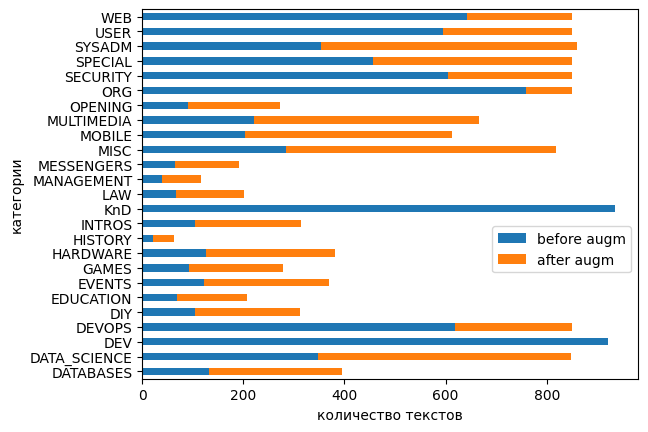

In [129]:
before_augm  = dict_count.values()
after_augm = dict_count1.values()

#after_augm1 = [x + y for x, y in zip(after_augm, before_augm)]
index = dict_count.keys()
df = pd.DataFrame({"before augm": before_augm,
                   "after augm": after_augm}, index=index)
ax = df.plot.barh(stacked=True)
ax.legend(loc='center right', bbox_to_anchor=(1, 0.35))
ax = plt.subplot()
plt.xlabel('количество текстов', axes=ax)
plt.ylabel('категории', axes=ax)

ax.figure.savefig('result_inc_dataset.pdf', bbox_inches='tight')

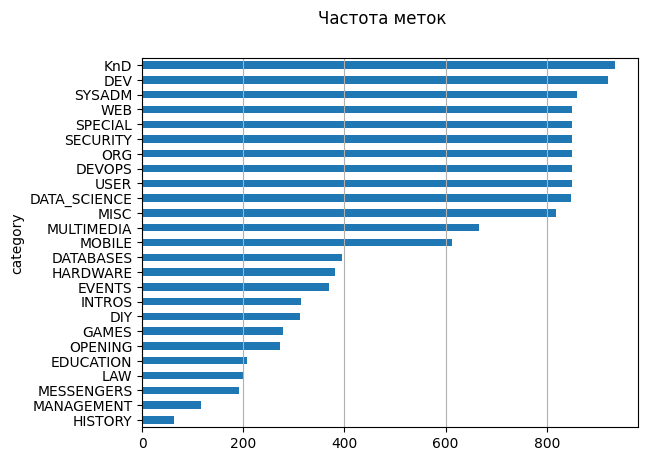

In [120]:
# объединенный df с синонимами и основным + перевод
fig, ax = plt.subplots()
fig.suptitle("Частота меток", fontsize=12)
df4['category'].reset_index().groupby('category').count().sort_values(by= 
       'index').plot(kind='barh', legend=False, 
        ax=ax).grid(axis='x')
plt.show()

## Верификация разработанных методов аугментации

In [152]:
text = 'Microsoft представила файловую систему \
новой технологии (NTFS), проприетарную файловую систему журналирования, \
в Windows NT 3.1 в 1993 году. С тех пор она заменила файловую систему таблицы размещения \
файлов (FAT) 1977 года во всех версиях Windows. В отличие от FAT, которую Microsoft в конечном \
итоге откроет для других пользователей, NTFS осталась частной.'

In [153]:
text = normalize_text(text)
text

'microsoft представила файловую систему новой технологии ntfs проприетарную файловую систему журналирования windows nt заменила файловую систему таблицы размещения файлов fat версиях windows отличие fat которую microsoft конечном итоге откроет пользователей ntfs осталась частной'

In [43]:
# парафразер
paraphraser([text], [0])

(['Микрософт представила файловую программу новой техники ntfs',
  'Microsoft представила файловой систему новой модели ntfs proприетарную программу журналирования Windows nt заменила программу таблицы файлов файлов fat версии Windows отличие между файлами fat версии Windows от типовой программы',
  'ntfs создан в качестве средств защиты для пользователей ntFs - новая файловая система Windows ntfs новая файловая система журналирования windows nt заменил файловую систему файловых таблиц таблицы размещений файлов в версиях Windows отличие файлов от ntfs, что может быть закрыто пользователями ntfs'],
 [0, 0, 0])

In [32]:
# обратный перевод
back_translation([text], [0])

(['Microsoft ввела файловую систему новой закрытой файловой системы Windows nt logs для замены файловой системы таблицы размещения файлов для толстых версий Windows разницы, которые Microsoft в конечном итоге будет открыт для пользователей nfs остаются конфиденциальными.'],
 [0])

In [33]:
# контекстная замена случайных токенов
contextual_replacement([text], [0])

(['microsoft представила файловую систему операционной системы и создать файловую программу журналирования windows nt ##fs файловую версию таблицы , файлов fat и в отличие от Microsoft microsoft в счете откроет пользователей и осталась .'],
 [0])

In [34]:
# контекстная вставка случайных токенов
contextual_insertion([text], [0])

(['Компания microsoft представила новую файловую операционную систему в новой технологии ntfs и проприетарную файловую операционную систему для журналирования windows , nt заменила файловую операционную систему таблицы для размещения старых файлов fat версиях windows в отличие fat которую microsoft конечном конечном итоге откроет для пользователей , ntfs осталась закрыта частной'],
 [0])

In [38]:
# замена случайных токенов синонимом (rusvectores)
synonym_replacement(text, '', 0.5, 'rusvectores')

12
файлов  пользователь
осталась  держаться
таблицы  диаграмма
частной  публичный
файловую  пользовательский
систему  механизм
проприетарную  кроссплатформенный
откроет  приоткрываться
пользователей  сервис
размещения  складирование
отличие  сходство


'microsoft представила пользовательский механизм новой технологии ntfs кроссплатформенный файловую систему журналирования windows nt заменила файловую систему диаграмма складирование пользователь fat версиях windows сходство fat которую microsoft конечном итоге приоткрываться сервис ntfs держаться публичный'

In [41]:
model = KeyedVectors.load_word2vec_format('220/model.bin', binary=True)
# замена случайных токенов синонимом (word2vec)
synonym_replacement(text, model, 0.5, 'word2vec')

12
файлов  -файл
технологии  техника
осталась  остаться
таблицы  диаграмма
размещения  размещений
проприетарную  кроссплатформенный
новой  собственный
систему  механизм
файловую  операционный
итоге  результат
заменила  заменить


'microsoft представила операционный механизм собственный техника ntfs кроссплатформенный файловую систему журналирования windows nt заменить файловую систему диаграмма размещений -файл fat версиях windows отличие fat которую microsoft конечном результат откроет пользователей ntfs остаться частной'

In [154]:
# удаление случайных токенов
random_deletion(text)

'microsoft файловую новой технологии ntfs файловую журналирования windows nt заменила файловую таблицы windows отличие которую microsoft итоге откроет пользователей ntfs частной'

In [155]:
# случайная вставка
random_insertion(text)

'операционный остаться механизм техника microsoft представила клиент файловую систему новой механизм технологии ntfs проприетарную -файл файловую систему журналирования диаграмма windows nt заменила файловую систему таблицы размещения механизм файлов fat размещений результат версиях windows отличие fat которую microsoft конечном итоге откроет пользователей являться ntfs осталась кэширование частной'

In [156]:
# обмен случайных слов позициями 
swap_words(text)

'представила файловую систему microsoft новой технологии ntfs проприетарную файловую систему windows журналирования nt файловую заменила таблицы систему размещения файлов fat версиях windows отличие которую microsoft fat итоге конечном откроет пользователей ntfs осталась частной'